<a href="https://colab.research.google.com/github/clairefielden/ADD/blob/master/Curriculum_Learning_Dockstream_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Reinforcement Learning with Curriculum and Production Objectives Demo`
**Aim**: The aim of this notebook is to illustrate how `Curriculum Learning` (CL) can improve the _Structure Based Drug Design_ design of molecules in a *Reinforcement Learning* (RL) setup.

**Research Paper**: View full [experiment design](https://github.com/clairefielden/ADD/blob/d269dacc6855e29b3f2793c4c2fc2a7f2b1a090d/Documentation/FLDCLA001%20-%20ADD%20Final%20Paper.pdf)

**Curriculum Learning**: The CL strategy is split into the *Curriculum Phase* and the *Production Phase*.
- *Curriculum Phase*: The `agent` progresses through successive `Curriculum Objectives` that become more complex. `Curriculum Progression Criterion` guide the agent towards a favourable region of *chemical space* in order to satisfy the `Production Objective`.
- *Production Phase*: When the `agent` has satisfied all `Curriculum Progression Criterion`, it moves into the *Production Phase*. The `Production Objective` is to generate ligands with optimal binding poses that inhibit the `target receptor`.

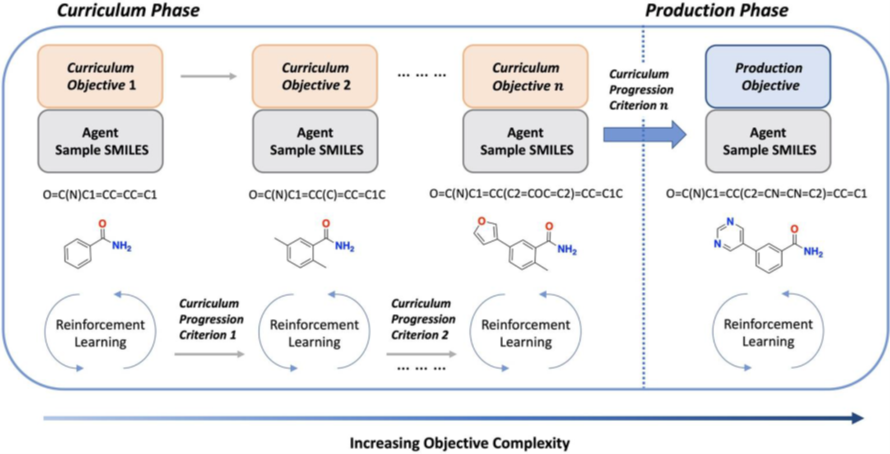

##Architecture
**Prior**: A generative model provided by [REINVENT](https://github.com/MolecularAI/ReinventCommunity) which possesses a great generative capacity and the potential to sample compounds from a vast region of chemical space. The role of the prior is to serve as a reference point for the likelihood of sampling given SMILES.For every batch of SMILES generated by the agent, the prior calculates the negative log-likelihood loss.

**Agent**: Initialized to have the same parameters as the `prior`. Has the same RNN architecture consisting of 3 stacked LSTM layers. Modifies the policy of the `prior` using transfer learning in order to shift the probability distribution from that of the prior towards a distribution that optimizes the `scoring functions`.

**Curriculum Scoring Functions**: Each molecule generated by the _agent_ will receive a score from 0 to 1 and this feedback is used to train the agent over time. The following scoring functions were provided by [RDKit](https://github.com/rdkit/rdkit/):
- `Curriculum Objective 1`: Tanimoto Similarity [(TM)](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/Fingerprints/FingerprintMols.py)
- `Curriculum Objective 2`: Quantitive Estimate of Drug-Likeness [(QED)](https://github.com/kevinid/molecule_generator/blob/master/rdkit_contrib/qed.py)
- `Curriculum Objective 3`: Synthetic Accessibility [(SA)](https://github.com/rdkit/rdkit/blob/master/Contrib/SA_Score/sascorer.py)

**Production Phase Scoring Function**: The _Curriculum Phase_ allows the agent to focus on chemical regions of interest. In the _Production Phase_, this knowledge will be used to generate ligands that can optimally bind to the PfPI4K target receptor, which is essential for malaria parasite’s development within an infected host. The scoring function for the generated ligands is provided using [DockStream](https://github.com/MolecularAI/DockStreamCommunity/blob/master/notebooks/demo_Glide.ipynb).

##Molecular Docking Prerequisites

1. Obtain a license to the [Schrödinger Software Suite](https://www.schrodinger.com/)
2. Have access to a GPU (for these experiments, the computational resources required were 3 GPUs and 30 CPU cores, provided by CSIR’s Centre for High Performance Computing [(CHPC)](https://www.chpc.ac.za/)
3. Generate the receptor grid using [Maestro](https://www.schrodinger.com/products/maestro)
  - Download a [PDB file](https://github.com/clairefielden/ADD/blob/d269dacc6855e29b3f2793c4c2fc2a7f2b1a090d/chem/4d0l.pdb) containing the interaction between the target receptor and a sample ligand
  - Use the Protein Preparation Wizard to create a grid around the target receptor's binding cavity
  - Download the receptor-grid file as a [zip file](https://github.com/clairefielden/ADD/blob/d269dacc6855e29b3f2793c4c2fc2a7f2b1a090d/models/pfpi4k_grid.zip).

<img src='https://drive.google.com/uc?id=1aWZ_UvmZ0rKUuxg8OXMxE3-js1mD8Uo7'>

##Cluster Use
1. Ensure you are using a GPU in your Runtime Evironment
2. Clone the github repo with all the necessary files: <br>
```bash
$ git clone https://clairefielden/ADD.git
$ cd ADD
```
3. Install [conda](https://docs.anaconda.com/free/anaconda/install/index.html): <br>
```bash
$ module load chpc/python/anaconda/3-2021.11
```
4. Install [Schrödinger](https://www.schrodinger.com/): <br>
```bash
$ module load chpc/schrodinger/2019-4
```
5. Create the environments
```bash
$ conda env create -f ./ADD/DockStream/environment.yml
$ conda env create -f ./ADD/Reinvent/reinvent.yml
```
6. Activate the environments: <br>
```bash
$ source /apps/chpc/anaconda/3-2021.11/etc/profile.d/conda.sh
$ source activate /home/<name>/.conda/envs/reinvent.v3.2
```
5. Compile the configuration files: <br>
  - Compiling json files for docking: [DockStream](https://github.com/MolecularAI/DockStreamCommunity/blob/master/notebooks/demo_Glide.ipynb)
  - Compiling json files for reinforcement learning: [REINVENT3.2](https://github.com/MolecularAI/ReinventCommunity/blob/master/notebooks/Reinforcement_Learning_Demo.ipynb)
  - The configuration files for these experiments are provided in the [experiments](https://github.com/clairefielden/ADD/tree/478e333503d9500fa8c1869d88dc01d9659998c2/experiments) subdirectory.
6. Run the experiment <br>
```
$ cd /mnt/lustre/users/<src_directory>
$ python ./ADD/Reinvent/input.py ./ADD/<experiments>/<experiment>/<CL_config_file>
```

##Measuring Synthesizability

The code for SA Score is based on work done by [Peter Ertl and Ansgar Schuffenhauer](http://www.jcheminf.com/content/1/1/8) and is publicly available on RDKit's [GitHub Repository](https://github.com/rdkit/rdkit/blob/master/Contrib/SA_Score/sascorer.py).
To add SA Score to the *Curriculum Learning* framework as a scoring function:
  1. Copy the [jaccard_distance.py](https://github.com/clairefielden/ADD/blob/478e333503d9500fa8c1869d88dc01d9659998c2/algorithms/jaccard_distance.py) file
  2. Navigate to `/home/<user_name>/.conda/envs/reinvent.v3.2/lib/python3.7/site-packages/reinvent_scoring/scoring/score_components/standard/jaccard_distance.py` and replace it with the copied file
  3. Ensure [fpscores.pkl.gz](https://github.com/clairefielden/ADD/blob/478e333503d9500fa8c1869d88dc01d9659998c2/algorithms/fpscores.pkl.gz) is in `/mnt/lustre/users/<src_directory>/ADD/algorithms`

In [ ]:
import numpy as np
from typing import List
from rdkit import Chem
from rdkit.Chem import RDConfig, rdMolDescriptors
import pickle
import math
import gzip
import os.path as op

from reinvent_scoring.scoring.component_parameters import ComponentParameters
from reinvent_scoring.scoring.score_components import BaseScoreComponent
from reinvent_scoring.scoring.score_summary import ComponentSummary

_fscores = None
abs_path = "/mnt/lustre/users/cfielden/fldcla001/ADD/algorithms/fpscores.pkl.gz"

class JaccardDistance(BaseScoreComponent):
    def __init__(self, parameters: ComponentParameters):
        super().__init__(parameters)

    def readFragmentScores(name='fpscores'):
        global _fscores
        # generate the full path filename:
        name = abs_path
        data = pickle.load(gzip.open(name))
        outDict = {}
        for i in data:
            for j in range(1, len(i)):
                outDict[i[j]] = float(i[0])
        _fscores = outDict


    def numBridgeheadsAndSpiro(self, mol, ri=None):
        nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
        nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
        return nBridgehead, nSpiro

    def syntheticAccess(self, mol):
        if _fscores is None:
            self.readFragmentScores()
        # fragment score
        fp = rdMolDescriptors.GetMorganFingerprint(mol,2)  # <- 2 is the *radius* of the circular fingerprint
        fps = fp.GetNonzeroElements()
        score1 = 0.
        nf = 0
        for bitId, v in fps.items():
            nf += v
            sfp = bitId
            score1 += _fscores.get(sfp, -4) * v
        score1 /= nf

        # features score
        nAtoms = mol.GetNumAtoms()
        nChiralCenters = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        ri = mol.GetRingInfo()
        nBridgeheads, nSpiro = self.numBridgeheadsAndSpiro(mol, ri)
        nMacrocycles = 0
        for x in ri.AtomRings():
            if len(x) > 8:
                nMacrocycles += 1

        sizePenalty = nAtoms**1.005 - nAtoms
        stereoPenalty = math.log10(nChiralCenters + 1)
        spiroPenalty = math.log10(nSpiro + 1)
        bridgePenalty = math.log10(nBridgeheads + 1)
        macrocyclePenalty = 0.
        # ---------------------------------------
        # This differs from the paper, which defines:
        #  macrocyclePenalty = math.log10(nMacrocycles+1)
        # This form generates better results when 2 or more macrocycles are present
        if nMacrocycles > 0:
            macrocyclePenalty = math.log10(2)

        score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

        # correction for the fingerprint density
        # not in the original publication, added in version 1.1
        # to make highly symmetrical molecules easier to synthetise
        score3 = 0.
        if nAtoms > len(fps):
            score3 = math.log(float(nAtoms) / len(fps)) * .5

        sascore = score1 + score2 + score3

        # need to transform "raw" value into scale between 1 and 10
        min = -4.0
        max = 2.5
        sascore = 11. - (sascore - min + 1) / (max - min) * 9.
        # smooth the 10-end
        if sascore > 8.:
            sascore = 8. + math.log(sascore + 1. - 9.)
        if sascore > 10.:
            sascore = 10.0
        elif sascore < 1.:
            sascore = 1.0

        return sascore

    def calculate_score(self, molecules: List) -> ComponentSummary:
        score = self._calculate_sa(molecules)
        score_summary = ComponentSummary(total_score=score, parameters=self.parameters)
        return score_summary

    def _calculate_sa(self, query_mols) -> np.array:
        sa_scores = []
        for mol in query_mols:
            try:
                sa_score = self.syntheticAccess(mol)
            except ValueError:
                sa_score = 0.0
            sa_scores.append(sa_score)
        return np.array(sa_scores, dtype=np.float32)


## Curriculum Learning Configuration File
The configuration file for the Reinforcement Learning Experiment implementing `Curriculum Learning` as a reward shaping mechanism is supplied below. The results of the `CL` experiments were compared to the baseline `RL` experiment, which is also supplied in the [experiments/benchmark](https://github.com/clairefielden/ADD/tree/478e333503d9500fa8c1869d88dc01d9659998c2/experiments/benchmark) subdirectory. In order to analyse the results of these experiments, the data will be logged using `tensorboard`.

In [ ]:
{
    "version": 3,
    "run_type": "curriculum_learning",
    "model_type": "default",
    "logging": {
        # add block to specify whether to run locally or not and
        # where to store the results and logging
        "sender": "http://0.0.0.1",
        "recipient": "local",
        "logging_frequency": 100, #how often logging takes place
        "logging_path": "/home/<user>/lustre/<src_directory>/ADD/results/<experiment>/progress.log", #name of the log file
        "result_folder": "/home/<user>/lustre/<src_directory>/ADD/results/<experiment>/results", #the output ligands from docking will go to this file
        "job_name": "Curriculum Learning Demonstration",
        "job_id": "CL Demo"
    },

##Setting up diversity filter and inception for Reinforcement Learning

* `diversity_filter`: If the agent becomes very focussed, it tends to produce the similar molecules over and over (because they return high scores). To enrich different scaffolds, we can activate the diversity filter, which will "bin" the molecules into groups (scaffolds). Once a given bin is full, all other molecules with the same scaffold will be penalized score-wise, effectively "pushing" the agent out of a local minimum in the score landscape thus enriching diversity.

* `inception`: A modified version of experience replay, used to memorize the compounds from each RL step. There is a limited memory space, so only the best compounds are retained in the memory once the limit is reached. The memory is updated at each step with better compounds pushing out the worse ones. The purpose of the experience replay is to randomly select a small batch of previously generated compounds that have been memorized and present it to the agent. This serves as a reminder of which SMILES were more successful and speeds up the learning process. At each RL step, a fraction of the inception memory is sampled and at random and added to the set of compounds generated by the agent. This means that early in the RL process, the agent will be driven towards a higher-scoring area of chemical space. This will speed up learning in the early stages and help the agent achieve a state of productivity sooner. Sometimes agents "linger around" for a while before they (by chance) happen to pick up a trace and generate interesting compounds. To speed up this very early exploration, we can *incept* a couple of promising molecules as list of `SMILES`.

* `curriculum_strategy`: This block holds all the parameters which are specific for the reinforcement running mode (see detailed description in the code). The prior and initial agent being used is from Reinvent. They are models that have been trained on a large compound library to ensure they have learned "basic chemical rules". While the prior does not change over the course of the training (its feedback will be used to keep the agent in the realm of good chemistry), the agent is updated each *epoch*. In this case we have used *augmented* `SMILES` representation of `CHEMBL` data for both the prior and to initialize the agent.

In [ ]:
"parameters": {
        "prior": "/home/<user>/lustre/<src_directory>/ADD/models/random.prior.new",
        "agent": "/home/<user>/lustre/<src_directory>/ADD/models/random.prior.new",
        "curriculum_type": "automated",
        "curriculum_strategy": {
            "name": "user_defined",
            "max_num_iterations": 500,
            "batch_size": 128,
            "learning_rate": 0.0001,
            "sigma": 128,
            "learning_strategy": {
                "name": "dap_single_query",
                "parameters": {
                    "sigma": 120
                }
            },
            "diversity_filter": {
                "name": "NoFilter",
                "bucket_size": 25,
                "minscore": 0.4,
                "minsimilarity": 0.4
            },
            "inception": {
                "smiles": [],
                "memory_size": 100,
                "sample_size": 10
            },

### Define the scoring function
Three curriculum objectives are defined:

1. *Tanimoto Similarity*: The Tanimoto Similarity is calculated by taking the intersection of two sets and dividing it by the sum of the sizes of the two sets. This gives a value between 0 and 1, where 0 indicates no similarity and 1 indicates perfect similarity. Here, we are trying to achieve high similarity to pre-existing anti-malerial drugs.
2. *QED*: Quantitative estimation of drug likeness, reflects the underlying distribution of molecular properties (eg. molecular weight and logP) as well as the presence of unwanted chemical functionalities. Makes use of an RDKit module.
3. *SA Score*: Specified the substructures in the generated scaffolds that should be penalized or rewarded based on chemical feasibility. This helps identify specific moeities that may occur in the generated compound that cause side-effects to humans and thus should not be considered for synthesis.

The complex objective of producing a suitable ligand to bind to the PfPI4k receptor is broken down into simpler constituent objectives. Corresponding gradients from sequential simpler tasks are more effective at traversing the optimization landscape and can accelerate convergence.

**Curriculum Progression Criteria**: For each objective, the agent must achieve the defined score before proceeding to the next objective. Only once all objectives in the curriculum are satisfied will it progress to the Production Objective. In this stage, the agent is in a state of productivity, thus sampling compounds in favourable areas of chemical space that satisfy the Production Objective. Agent policy update is maintained in the Production Phase to ensure the agent continues to sample favourable compounds from diverse minima.

In [ ]:
    # Curriculum Objectives are all the scoring functions that are to be sequentially activated
               "curriculum_objectives": [
                 {
                    "scoring_function": {
                        "name": "custom_product",
                        "parallel": true,
                        "parameters": [
                            {
                                "component_type": "tanimoto_similarity",
                                "name": "Tanimoto Similarity",
                                "specific_parameters": {
                                    "smiles": [
                                        "C1=CC2=C(C=CC=N2)N=C1",
                                        "C1=CC=NC(=C1)N",
                                        "C1=CC2=NC=CN2N=C1"
                                    ]
                                },
                                "weight": 1
                            }
                        ]
                    },
                    "score_threshold": 0.25
                },
                {
                    "scoring_function": {
                        "name": "custom_product",
                        "parallel": true,
                        "parameters": [
                            {
                                "component_type": "qed_score",
                                "name": "QED Score",
                                "weight": 1
                            }
                        ]
                    },
                    "score_threshold": 0.5
                },
                {
                    "scoring_function": {
                        "name": "custom_product",
                        "parallel": true,
                        "parameters": [
                            {
                                "component_type": "jaccard_distance",
                                "name": "SA Score",
                                "weight": 1
                            }
                        ]
                    },
                    "score_threshold": 5
                }
            ]
        },

**Production Strategy**: A new Diversity Filter and Inception can be initialized. We keep the Curriculum Phase Inception here as we want previous top compounds to be considered. Moreover, we continue to use NoFilter so the agent is not penalized for sampling the same scaffold as our only goal in this demo is to generate the target scaffold. Using a Diversity Filter would penalize the agent and eventually give compounds possesing the target scaffold a score of 0.

In [ ]:
        "production_strategy": {
            "name": "standard",
            "retain_inception": true,
            "number_of_steps": 100,
            "batch_size": 128,
            "learning_rate": 0.0001,
            "sigma": 128,
            "learning_strategy": {
                "name": "dap_single_query",
                "parameters": {
                    "sigma": 120
                }
            },
            "diversity_filter": {
                "name": "NoFilter",
                "bucket_size": 25,
                "minscore": 0.4,
                "minsimilarity": 0.4
            },
            "inception": {
                "smiles": [],
                "memory_size": 100,
                "sample_size": 10
            },
            "scoring_function": {
                "name": "custom_product",
                "parallel": true,
                "parameters": [
                    {
                        "component_type": "dockstream",
                        "name": "Glide LigPrep Docking",
                        "weight": 1,
                        "specific_parameters": {
                            "transformation": {
                                "transformation_type": "reverse_sigmoid",
                                "low": -11,
                                "high": -5,
                                "k": 0.25
                            },
                            "configuration_path": "/home/<user>/lustre/<src_directory>/ADD/<experiments>/<experiment>/docking_config_file.json",
                            "docker_script_path": "/home/<user>/lustre/<src_directory>/ADD/DockStream/docker.py",
                            "environment_path": "/home/cfielden/.conda/envs/DockStream/bin/python"
                        }
                    }
                ]
            }
        }

## Molecular Docking Configuration File
We create a JSON file that will load the parameters into the program as an entry point. Set the run type to curriculum learning.

**DockStream**: This docking backend provides a `docker.py` algorithm as entry point, which allows REINVENT to use Glide as a scoring function.

**Ligand preparation**: Makes use of Schrodinger's LigPrep module, Glide with LigPrep will be used as the molecular docking component.

**Target preparation**: The receptor can be set up with Maestro (Schrodinger's GUI), which results in a zip file containing all structural and force-field information. Maestro was used to create the docking grid for the PfPI4K receptor and can be found in the [models]() subdirectory.

In [ ]:
# specify the embedding and docking JSON file as a dictionary and write it out
{
  "docking": {
    "header": {
      "logging": {
        "logfile": "/home/<user>/lustre/<src_directory>/ADD/results/<experiment>/docking.log"   #docking will be logged to this file to ensure it is taking place
      }
    },
    "ligand_preparation": {
      "embedding_pools": [
        {
          "pool_id": "Ligprep_pool",
          "type": "Ligprep",
          "parameters": {
            "prefix_execution": "module load schrodinger/2019-4",   #load the Ligprep from the Schrodinger module
            "parallelization": {
              "number_cores": 30    #parralelized to use 30 cores
            },
            "use_epik": {
              "target_pH": 7.0,
              "pH_tolerance": 2.0
            },
            "force_field": "OPLS3e"
          },
          "input": {
            "standardize_smiles": false,    #SMILES generated by the agent during RL are input directly to DockStream using 'console mode'
            "input_path": "console"
          }
        }
      ]
    },
    "docking_runs": [
      {
        "backend": "Glide",
        "run_id": "Glide_run",
        "input_pools": [
          "Ligprep_pool"
        ],
        "parameters": {
          "prefix_execution": "module load schrodinger/2019-4",
          "parallelization": {
            "number_cores": 30
          },
          "glide_flags": {
            "-HOST": "localhost"
          },
          "glide_keywords": {
            "AMIDE_MODE": "trans",
            "EXPANDED_SAMPLING": "True",
            "GRIDFILE": "/home/<user>/lustre/<src_directory>/ADD/models/pfpi4k_grid.zip", #the path to the grid for the target receptor
            "NENHANCED_SAMPLING": "2",
            "POSE_OUTTYPE": "ligandlib_sd",
            "POSES_PER_LIG": "3",
            "POSTDOCK_NPOSE": "15",
            "POSTDOCKSTRAIN": "True",
            "PRECISION": "HTVS",
            "REWARD_INTRA_HBONDS": "True"
          }
        },
        "output": {
          "poses": {
            "poses_path": "/home/<user>/lustre/<src_directory>/ADD/results/<experiment>/results/ligands_docked.sdf",
            "overwrite": false
          },
          "scores": {
            "scores_path": "/home/cfielden/lustre/fldcla001/ADD_Results/results/<experiment>/results/ligand_scores.csv",
            "overwrite": false
          }
        }
      }
    ]
  }
}


## Visualizing results
In order to analyze the results, download the resulting file and run `tensorboard`:

```
# start tensorboard
tensorboard --logdir progress.log
```
Navigate to [http://localhost:6006/](http://localhost:6006/#timeseries)

<img src='https://drive.google.com/uc?id=1oITTyk-QeNAPMvD42_sfbt4pNHgejZmb'>

## Comparing data
The compounds generated at the end of the *Production Phase* can be compared either through TensorBoard or through the `csv` files downloaded into the results folder during training. There are also `sdf` files containing exact coordinates for each conformation. The results for all the experiments can be found in the [results](https://github.com/clairefielden/ADD/tree/478e333503d9500fa8c1869d88dc01d9659998c2/results) file.


<img src='https://drive.google.com/uc?id=1pJKiBrhFOBlN2sEHff180_UiCtPFgoWt'>

##Results

This work displayed the exploitative (no diversity filter) and sophisticated (high thresholds) curriculum to be the most productive. It also displayed the ability to optimize for SA Score and Binding Affinity simultaneously. The best scoring liagnd obtained a GlideScore of **±−5.125 kcal/mol** and a SA Score of **±6.961**. It has been exported as a chemfig and can be accessed in the [chemistry file](https://github.com/clairefielden/ADD/tree/478e333503d9500fa8c1869d88dc01d9659998c2/chem), along with the other antimalarials with which it was compared.

<img src='https://drive.google.com/uc?id=1N-STpAeEazP2AvjMlZz7abjOCMtvW9Au'>